In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

In [2]:
df = pd.read_csv('socialmobility.csv')
df['combo'] = df['father'] + '_' + df['son']
df = df[['combo', 'count']]
df

,combo,count
0,farm_farm,703
1,farm_unskilled,1478
2,farm_skilled,1430
3,farm_professional,1109
4,unskilled_farm,58
5,unskilled_unskilled,1756
6,unskilled_skilled,1630
7,unskilled_professional,1568
8,skilled_farm,63
9,skilled_unskilled,1453


There are 16 categories, we can start with uniform Dirichlet distribution over $\vec{p}$ with $\vec{\alpha} = (1, \cdots, 1)$.

$$Dirichlet(p_{1}, p_{2}, \cdots, p_{16}) | (1, 1, \cdots, 1)$$

Given that info, we know that the Dirichlet distribution is a conjugate prior for our Multinomial distribution. Therefore the posterior is also a Dirichlet distribution. 
The new alpha is given as $\vec{\alpha_{p\text{post}}} = \vec{\alpha_{\text{prior}}} + \vec{x}$

In [3]:
df['posterior'] = df['count'] + 1
df

,combo,count,posterior
0,farm_farm,703,704
1,farm_unskilled,1478,1479
2,farm_skilled,1430,1431
3,farm_professional,1109,1110
4,unskilled_farm,58,59
5,unskilled_unskilled,1756,1757
6,unskilled_skilled,1630,1631
7,unskilled_professional,1568,1569
8,skilled_farm,63,64
9,skilled_unskilled,1453,1454


In [4]:
samples = sts.dirichlet.rvs(list(df['posterior']), size=10000000)

In [5]:
samples

array([[0.03270262, 0.06873217, 0.06919225, ..., 0.03579328, 0.05536627,
        0.15716867],
       [0.03403706, 0.0735984 , 0.06683935, ..., 0.03424177, 0.05636677,
        0.15879942],
       [0.03311361, 0.06854897, 0.06771622, ..., 0.03515724, 0.05535144,
        0.15729075],
       ...,
       [0.03624748, 0.06729414, 0.07106045, ..., 0.03378269, 0.0554512 ,
        0.15021294],
       [0.03219587, 0.07068669, 0.06921273, ..., 0.03423453, 0.05782179,
        0.15589977],
       [0.03217395, 0.07064052, 0.06627791, ..., 0.03781145, 0.05621429,
        0.15643668]])

The `unskilled_skilled` category with index 6 represents the situation whereby the father was unskilled and their son was skilled. To calculate the 95% probability of this situaion we use `numpy`.

In [6]:
percentiles = np.percentile(samples[:, 6], [0.025, 0.975])

print(f"95% confidence interval = {percentiles}")

95% confidence interval = [0.07097085 0.07298615]


Doing the same thing for a father that works on the farm and their son works as a professional `farm_professional` index 3

In [7]:
percentiles = np.percentile(samples[:, 3],  [0.025, 0.975])

print(f"95% confidence interval = {percentiles}")

95% confidence interval = [0.04735835 0.04902474]


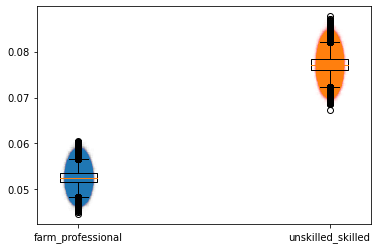

In [8]:
to_plot = []
for i in [3, 6]:
    y = samples[:, i]
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i, 0.04, size=len(y))
    to_plot.append(y)
    plt.plot(x, y, '.', alpha=0.002)
    
plt.boxplot(to_plot, positions=[3, 6], labels=['farm_professional', 'unskilled_skilled'])
plt.show()